<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

# Testing

Further reading on Testing:
- [The official Pytest docs](https://docs.pytest.org/en/7.1.x/getting-started.html)
- [The Turing Way](https://the-turing-way.netlify.app/reproducible-research/testing.html)
- [Essential Software Engineering for Researchers](https://imperialcollegelondon.github.io/grad_school_software_engineering_course/l2-01-testing_overview/index.html)

Ok we can finally start writing and running some tests!

I copied some of the initial tests that we did in chapter 1 into `test_energy.py` installed pytest into my development environment with `pip install pytest`. If you're using conda you need to use `conda install pytest`, and now I can run the `pytest` command in the `mcmc` directory. Pytest will automatically discover our tests and run them, to do this it relies on their being python files with functions named `test_\*` which it will run.

If that doesn't work and complains it can't find MCFF, try `python -m pytest`, this asks python to find a module and run it, which can be useful to ensure you're running pytest inside the correct environment. I ran into this problem because I used `pip install pytest` into a conda environment when I should have done `conda install pytest`.

But hopefully you can get it working and get a lovely testy output! I've embedded a little video of this below but if it doesn't load, check out the [link](https://asciinema.org/a/498583)

In [1]:
%%html 
<div style="max-width:700px;margin:auto;"><script id="asciicast-498583" src="https://asciinema.org/a/498583.js" async></script></div>

We can also add a few lines to `pyproject.toml` to tell pytest where to find our tests:
```toml
[tool.pytest.ini_options]
minversion = "6.0"
testpaths = [
    "tests",
]
```

## Basic Testing with Pytest

Take a look at `tests/test_energy.py`. You can see that I've done some imports, setup some test states and then defined two testing functions:

```python
# Note that only functions whose name begins with test_ get run by pytest
def E_prediction_all_the_same(L): 
    "The exact energy in for the case where all spins are up or down"
    return -(4*(L - 2)**2 + 12*(L-2) + 8)

def test_exact_energies():
    for state in [all_up, all_down]:
        L = state.shape[0]
        assert energy(state) == E_prediction_all_the_same(L)
```

I will defer to external resources for a full discussion of the philosophy of testing, but I generally think of tests as an aid to my future debugging. If I make a change that breaks something then I want my tests to catch that and to make it clear what has broken. As such I generally put tests that check very basic properties of my code early on in the file and then follow them with tests that probe more subtle things or more obscure edges cases.

`test_exact_energies` checks that the energies of our exact states come out as we calculated they should in chapter 1. This is testing a very limited space of the possible inputs to `energy` so we'd like to find some way to be more confident that our implementation is correct.

One is to test multiple independent implementations against one another: `test_energy_implementations` checks our numpy implementation against our numba one. This should catch implementation bugs because it's unlikely we will make the same such error in both implementations. 

```python
def test_energy_implementations():
    for state in states:
        assert np.allclose(energy(state), energy_numpy(state))
```

However, if we have made some logical errors in how we've defined the energy, that error will likely appear in both implementations and thus won't be caught by this. 

Generally what we will do now, is that as we write more code or add new functionality we will add tests to check that functionality.

## Coverage Testing

A useful little trick for testing, are tools like pytest-cov that can measure *coverage*, that is, the amount of your code base that is activated by your tests. Unfortunately Numba does not play super well with pytest-cov, so we have to turn off numba to generate the test report using an environment variable.

```bash
(recode) tom@TomsLaptop ReCoDE_MCMCFF % pip install pytest-cov # install the coverage testing plugin
(recode) tom@TomsLaptop ReCoDE_MCMCFF % NUMBA_DISABLE_JIT=1 pytest --cov=MCFF --cov-report=term

================================================== test session starts ==================================================
platform darwin -- Python 3.9.12, pytest-7.1.1, pluggy-1.0.0
rootdir: /Users/tom/git/ReCoDE_MCMCFF
plugins: hypothesis-6.46.10, cov-3.0.0
collected 3 items                                                                                                       

code/tests/test_energy.py ..                                                                                      [ 66%]
code/tests/test_energy_using_hypothesis.py .                                                                      [100%]

---------- coverage: platform darwin, python 3.9.12-final-0 ----------
Name                           Stmts   Miss  Cover
--------------------------------------------------
code/src/MCFF/__init__.py          0      0   100%
code/src/MCFF/ising_model.py      22      3    86%
code/src/MCFF/mcmc.py             14     14     0%
--------------------------------------------------
TOTAL                             36     17    53%


=================================================== 3 passed in 1.89s ===================================================
```

Ok so this is telling us that we currently test 86% of the lines in ising_model.py. We can also change `--cov-report=html` to get a really nice `html` output which shows which parts of your code aren't being run.

A warning though, testing 100% of your lines of code doesn't mean it's correct, you need to think carefully about the data you test on, try to pick the hardest examples you can think of! What edge cases might there be that would break your code? Zero, empty strings and empty arrays are classic examples.

## Advanced Testing Methods: Property Based Testing

I won't do into huge detail here, but I thought it would be nice to make you aware of a nice library called `Hypothesis` that helps with this problem of finding edge cases. `Hypothesis` gives you tools to generate randomised inputs to functions, so as long as you can come up with some way to verify the output is correct or has the correct _properties_ (or just that the code doesn't throw and error!) then this can be a powerful method of testing. 


Take a look in `test_energy_using_hypothesis.py`
```python
from hypothesis.extra import numpy as hnp

@given(hnp.arrays(dtype = int,
                 shape = hnp.array_shapes(min_dims = 2, max_dims = 2),
                 elements = st.sampled_from([1, -1])))
def test_generated_states(state):
    assert np.allclose(energy(state), energy_numpy(state))
```
You tell Hypothesis how to generate the test data, in this case we use some numpy specific code to generate 2 dimensional arrays with `dtype = int` and entries randomly sampled from `[1, -1]`. We use the same trick as before of checking two implementations against one another.

## Testing Stochastic Code

We have an interesting problem here, most testing assumes that for the same inputs we will always get the same outputs but our MCMC sampler is a stochastic algorithm. So how can we test it? I can see three mains routes we can take:

- Fix the seed of the random number generator to make it deterministic
- Do statistical tests on the output 
- Use property based testing (see above)

### Fixed Seeds
The random number generators we typically use are really pseudo-random number generators: given a value called a seed they generate a deterministic pattern that looks for most purposes like a random sequence. Typically, the seed is determined by something that is _more random_ such as a physical random number generator. However, if we fix the seed we can create reproducible plots and test our code more easily!

In [2]:
seed = [
    2937053738,
    1783364611,
    3145507090,
]  # generated once with rng.integers(2**63, size = 3) and then saved

# New Style
# numba doesn't yet support this so I haven't used it in our code
# but if you aren't using numba then you should get used to this new style)
from numpy.random import default_rng

rng = default_rng(seed=23)
vals = rng.standard_normal(10)

# Old style
from numpy import random

random.seed(seed)
vals2 = random.standard_normal(10)

vals, vals2  # note that the two styles do no give the same results

(array([ 0.55326059,  0.21760061, -0.05798999, -2.31893609,  0.43149417,
        -2.12627978,  0.90992122,  0.60596557,  0.83005665,  0.82769834]),
 array([-0.57820285, -0.65570117,  1.60871517, -0.83666294,  2.03363763,
         0.44904314,  0.31099544, -0.85810422, -0.87923828,  0.96426779]))

However, this has a major drawback, if we want this to work we must always generate the same random numbers in the same order and use them in the same way if we want the output to be the same. This is a problem because we might want to make a change to our MCMC sampler in a way that changes the way it calls the rng but still want to compare it to the previous version. In this case we have to use statistical tests instead.

### Statistical Tests
If we want to verify that two different implementations of our algorithm agree or that the output matches our expectations, we can use something like a t-test to check our samples. Now this gets complicated very fast but bear with me for this simple example:


Over 10 samples we got an average color of -0.00018 +/- 0.100228
That's -0.00018 +/- 55682%

The standard error of the mean is about 1245%

The p value when comparing that with 0 is 0.94
p > 0.1 : True




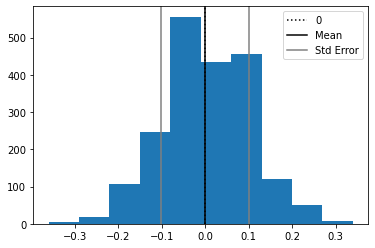

In [3]:
import numpy as np
from scipy import stats
from MCFF.mcmc import mcmc_generator
from matplotlib import pyplot as plt


### The measurement we will make ###
def average_color(state):
    return np.mean(state)


### Simulation Inputs ###
N = 10  # Use an NxN system
T = 1000  # What temperatures to use
steps = 2000  # How many times to sample the state
stepsize = N**2  # How many individual monte carlo flips to do in between each sample
initial_state = np.ones(shape=(N, N))  # the initial state to use

### Simulation Code ###
average_color_data = np.array(
    [
        average_color(s)
        for s in mcmc_generator(initial_state, steps=steps, stepsize=stepsize, T=T)
    ]
)


mean, std_dev = np.mean(average_color_data), np.std(average_color_data)
std_err = std_dev / np.sqrt(steps)

p_value = stats.ttest_1samp(average_color_data, 0).pvalue
print(
    f"""
Over {N} samples we got an average color of {mean:g} +/- {std_dev:g}
That's {mean:g} +/- {std_dev/abs(mean)*100:.0f}%

The standard error of the mean is about {std_err/abs(mean)*100:.0f}%

The p value when comparing that with 0 is {p_value:.2g}
p > 0.1 : {p_value > 0.1}

"""
)
f, ax = plt.subplots()
ax.hist(average_color_data)
ax.axvline(0, linestyle="dotted", color="k", label="0")
ax.axvline(mean, color="k", label="Mean")
ax.axvline(mean + std_dev, color="grey", label="Std Error")
ax.axvline(mean - std_dev, color="grey")
ax.legend()

There are three things happening here:

1. We are taking 2000 samples of a random variable X, those samples has some mean $m$ and standard deviation $\sigma_X$, the mean is the center of mass of the above histogram and the standard deviation is a measure of how wide it is.

2. However, what we actually want to do is ask "How close is the mean to 0?", to answer that we need to know how much we expect the mean to vary by when we rerun the calculation. Turns the mean of N samples of a variable X then the mean varies by 
    $$\sigma_m = \sigma_X / \sqrt{N}$$
    this is usually called the standard error of the mean.

3. Each time we run this code, we estimate the mean and the standard error of the mean, when it comes out to be a lot more than 100% then our t-test is very confident that the data is consistent with the true mean being 0. However, when it's less than 100% we get a smaller p_value and this is saying that we should suspect that maybe the mean is not 0 after all.

<img style="max-width:700px;margin:auto;" src = "https://imgs.xkcd.com/comics/p_values.png" alt = "An xkcd comic with a diagram of p values, saying that small ones are highly significant and giving humorous excuses for why larger ones are still intersting">

So to do our test, we check that the p value is less than some arbitrary cut-off such as 0.1 or 0.01. This test should usually pass if the mean is in fact close to zero, and it should fail if the mean is not zero. However, due to random variation it can also fail randomly.

This is just one of those things that you can't really do anything about. Incidentally this can be used in reverse to generate fake "highly significant" scientific results in a practice called p-hacking. As usual XKCD has [explained this](https://xkcd.com/882/) better than I ever could.

## Test Driven Development

I won't talk about TDD much here, but it's likely a term you will hear at some point. It essentially refers to the practice of writing tests as part of your process of writing code. Rather than writing all your code and then writing tests for them. You could instead write some or all of your tests upfront and then write code that passes them. 

This can be an incredibly productive way to work, it forces you think about the structure and interface of your software before you start writing it. It also gives you nice incremental goals that you can tick off once each test starts to pass, gamification maybe?

## Autoformaters
Further reading on the topic of autoformatters:
- [The Turing Way](https://the-turing-way.netlify.app/reproducible-research/code-quality/code-quality-style.html)
- [Essential Software Engineering for Researchers](https://imperialcollegelondon.github.io/grad_school_software_engineering_course/l1-02-tools-II/index.html)

While we're doing things that will help keep our code clean and tidy in the future, I would recommend installing a code formatter like `black`. This is a program that enforces a particular formatting style on your code by simply doing it for you. At first this sounds a bit weird, but it has a few benefits:

- It makes git diffs as small as possible because formatting changes never show up
- It means you never have to discuss with your collaborators about code formatting, something which can waste a lot of time!

Here I will show you how to set up `black` as a pre-commit hook, this means it runs before you commit anything to git, which is probably the best time to do it. We'll use a helper tool called [pre-commit](https://pre-commit.com/).

```bash
pip install pre-commit
pre-commit sample-config >> .pre-commit-config.yaml # Generate an initial config
```
Now we add some additional lines to the `.pre-commit-config.yaml` config file to set up black:
```yaml
-   repo: https://github.com/psf/black
    rev: 21.12b0
    hooks:
    -   id: black
    -   id: black-jupyter
```
And finally `pre-commit install` will make this run every time you commit to git. It's worth running it manually once the first time to check it works: `pre-commit run --all-files`. Running this I immediately got a cryptic error that, on googling, turned out to be that something broke in version 21.12b0 of `21.12b0`. Running `precommit autoupdate` fixed this for me by updated `black` to a later version. Running `pre-commit run --all-files` a second time now gives me:
```bash
(recode) tom@TomsLaptop ReCoDE_MCMCFF % pre-commit run --all-files
trim trailing whitespace.................................................Passed
fix end of files.........................................................Passed
check yaml...........................................(no files to check)Skipped
check for added large files..............................................Passed
black....................................................................Passed
(recode) tom@TomsLaptop ReCoDE_MCMCFF % 
```

Now whenever you commit anything, `black` will autoformat it before it actually gets committed. I'll test this for myself by putting
```python
def ugly_litte_one_liner(a,b,c): return " ".join([a,b,c/2. +3])
```
in a code cell below and we'll see how `black` formats it. The only gotcha here is that you have to reload Jupyter notebooks from disk in order to see the changes that `black` makes.

In [4]:
def ugly_litte_one_liner(a, b, c):
    return " ".join([a, b, c / 2.0 + 3])

Finally, be aware that if you try to commit code with incorrect syntax then black will just error and prevent it, this is probably a good thing, but there may be the occasional time when that's a problem.

In [5]:
%load_ext watermark
%watermark -n -u -v -iv -w -g -r -b -a "Thomas Hodson" -gu "T_Hodson"

Author: Thomas Hodson

Github username: T_Hodson

Last updated: Mon Jul 18 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

Git hash: 03657e08835fdf23a808f59baa6c6a9ad684ee55

Git repo: https://github.com/ImperialCollegeLondon/ReCoDE_MCMCFF.git

Git branch: main

matplotlib: 3.5.1
scipy     : 1.7.3
numpy     : 1.21.5

Watermark: 2.3.1

